In [1]:
import os
import glob
import numpy as np
import natsort
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
import torchvision
import torch
import torch.nn as nn

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as TF
import sklearn
from sklearn.model_selection import train_test_split

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3,4,5,6,7"

In [6]:
# define train/test transforms
transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
class BU101(torch.utils.data.Dataset):
    def __init__(self, split, *args, **kwargs):
        # common data attribute
        self.data = ImageFolder(*args, **kwargs)
        
        files = natsort.natsorted(
            glob.glob(os.path.join(kwargs.get("root"), '*', '*')))
        train_files, test_files = train_test_split(files, random_state=0)
        
        # dataset samples to get indices of train(or test) files
        ds_samples = np.array(self.data.samples)[:, 0].tolist()
        self.imgs = test_files if split == 'test' else train_files  # list of image path to use
        self.split = split
        
        # pos of train(or test) files
        self.pos = [ ds_samples.index(file) for file in self.imgs ]
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img, lab = self.data[self.pos[idx]]
        vid, _ = self.data.samples[self.pos[idx]]
                
        return img, lab, vid

In [8]:
IMG_ROOT = '/data/torch_data/BU101/images'
VALID_SIZE = 0.2
BATCH_SIZE = 512
NUM_WORKERS = 32
FINE_TUNE = True

datasets = {
    split: BU101(root=IMG_ROOT, transform=transforms[split], split=split) for split in ['train','valid','test']
}

In [9]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from torch.utils.data import DataLoader

def get_train_valid_test_loader(train_ds, valid_ds, test_ds, 
                                valid_size, batch_size, n_threads):
    
    num_train = len(train_ds)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    # shuffle to prevent memorizing
    np.random.seed(0)
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(train_ds,
                              batch_size=batch_size,
                              sampler=train_sampler,
                              num_workers=n_threads, pin_memory=True)
    valid_loader = DataLoader(valid_ds,
                              batch_size=batch_size,
                              sampler=valid_sampler,
                              num_workers=n_threads, pin_memory=True)
    test_loader = DataLoader(test_ds,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=n_threads, pin_memory=True)

    return train_loader, valid_loader, test_loader


In [10]:
dataloaders = get_train_valid_test_loader(
    train_ds=datasets['train'], valid_ds=datasets['valid'], test_ds=datasets['test'],
    valid_size=VALID_SIZE, batch_size=BATCH_SIZE, n_threads=NUM_WORKERS)

dataloaders = dict(zip(['train','valid','test'], dataloaders))

# Check dataset

['HighJump', 'FloorGymnastics', 'BodyWeightSquats', 'JumpingJack', 'PlayingFlute', 'HandstandWalking', 'PlayingFlute', 'LongJump', 'WallPushups', 'BrushingTeeth', 'BandMarching', 'Shotput', 'PlayingViolin', 'PlayingPiano', 'BlowingCandles', 'JugglingBalls']


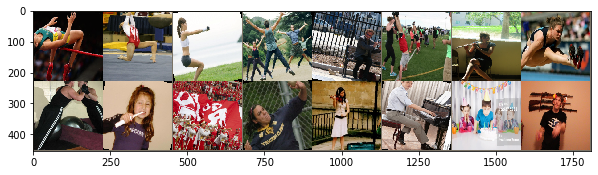

In [11]:
train_dl_iter = iter(dataloaders['train'])
imgs, labs, _ = train_dl_iter.next()

from torchvision.utils import make_grid

def denormalize_img(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    shapes = (-1,) + (1,) * (img_tensor.dim()-1)
    mean = torch.as_tensor(mean).view(shapes)
    std = torch.as_tensor(std).view(shapes)
    img_tensor = (img_tensor * std + mean).permute(1,2,0)
    
    return img_tensor

plt.figure(figsize=(10,10))
plt.imshow(denormalize_img(make_grid(imgs[:16])))

idx2class = { v:k for k,v in dataloaders['train'].dataset.data.class_to_idx.items() }
class_names = [ idx2class[i] for i in labs.numpy() ]
print(class_names[:16])

In [12]:
# def showClsDistribution(ds):
#     labs, cnts = np.unique([ 
#         os.path.basename(os.path.dirname(p)) for p in ds.imgs ], return_counts=True)

#     title = ds.split
    
#     plt.figure(figsize=(15,15))
#     plt.barh(labs, cnts)
#     plt.title('Class Distribution of ' + title + ' dataset', fontdict={'fontsize': 20})

# showClsDistribution(datasets['train'])
# showClsDistribution(datasets['test'])

In [13]:
def init_model(use_pretrained, fine_tune, multi_gpu=True):
    model = models.resnet101(pretrained=use_pretrained)

    if not FINE_TUNE:
        for parameter in model.parameters():
            parameter.requires_grad = False

    # 새로운 fully-connected classifier layer 를 만들어줍니다. (requires_grad 는 True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, 101)
    
    if multi_gpu:
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
            model = nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

    if torch.cuda.is_available():
        model = model.cuda()
    
    return model

model = init_model(use_pretrained=True, fine_tune=FINE_TUNE, multi_gpu=True)

Let's use 8 GPUs!


In [14]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.000027, weight_decay=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
dataset_sizes = {'valid': int(np.floor(len(datasets['train'])*VALID_SIZE)),
                 'test': len(datasets['test'])
                }
dataset_sizes['train'] = len(datasets['train'])-dataset_sizes['valid']

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            dl = iter(dataloaders[phase])
            
            for _ in tqdm.tqdm(range(len(dl)), desc='[{}] epoch-{}'.format(phase, epoch)):
                inputs, labels, _ = dl.next()
                
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if scheduler and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model   # return best model


In [ ]:
model_ft = train_model(model, criterion, optimizer, scheduler=None, num_epochs=25)

# Save fine-tuned model

In [ ]:
MODEL_PATH = '../ckpt_repos/ResNet2D_ft_BU101/model.pt'
os.system(f'mkdir -p {os.path.dirname(MODEL_PATH)}')
torch.save(model_ft.module.state_dict(), MODEL_PATH)

# Load fine-tuned model

In [17]:
MODEL_PATH = '../ckpt_repos/ResNet2D_ft_BU101/model.pt'
model = init_model(use_pretrained=True, fine_tune=FINE_TUNE, multi_gpu=False)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

# Evaluation

In [18]:
def check_Ncorrects(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k)
    return res

def eval_accuracy(model, phase='test'):
    running_top_1_corrects = 0
    running_top_5_corrects = 0
    
    model.eval()

    with torch.no_grad():
        dl = iter(dataloaders[phase])

        for _ in range(len(dl)):
            inputs, labels, _ = dl.next()
            
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            
            top1_correct, top5_correct = check_Ncorrects(outputs, labels, topk=(1,5))
            
            running_top_1_corrects += top1_correct
            running_top_5_corrects += top5_correct
    
    top1_acc = running_top_1_corrects.double() / dataset_sizes[phase]
    top5_acc = running_top_5_corrects.double() / dataset_sizes[phase]
    
    return top1_acc, top5_acc
            

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10,10))
    

    with torch.no_grad():
        dl = iter(dataloaders['valid'])

        for _ in range(len(dl)):
            inputs, labels, _ = dl.next()
            
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('actual : {} \n predicted: {}'.format(idx2class[labels[j].item()], 
                                                                   idx2class[preds[j].item()]))
                plt.imshow(denormalize_img(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    return
        model.train(mode=was_training)
        
# visualize_model(model, num_images=20)
top1_acc, top5_acc = eval_accuracy(model, phase='test')

print('Top1 ACC : ,', top1_acc, 'Top5 ACC : ', top5_acc)

Top1 ACC : , tensor(0.8877, device='cuda:0', dtype=torch.float64) Top5 ACC :  tensor(0.9792, device='cuda:0', dtype=torch.float64)


In [19]:
m_list = []

def hook_fn(m, inp, out):
    global m_list
    m_list.append(out)

named_modules = [ (name, module) for name,module in model.named_modules() \
                          if (name and type(module) != nn.Sequential and type(module) != models.resnet.BasicBlock) \
                              and type(module) != nn.ReLU ]

# register hook for activation visualization
names = []
for name, module in named_modules:
    names.append(name)
    module.register_forward_hook(hook_fn)

In [20]:
import torch
import numpy as np
from scipy.ndimage import zoom
from IPython.core.debugger import set_trace
import cv2

def generate_grad_cam(m_dict, c_index, activation_layer):
    y_c = m_dict['fc'][0, c_index]
    A_k = m_dict[activation_layer]
    
    grad_val = torch.autograd.grad(y_c, A_k, retain_graph=True)[0].data

    # move CUDA tensor to CPU
    A_k = A_k.cpu()
    grad_val = grad_val.cpu()

    # remove batch dim
    conv_out = A_k.data[0].numpy()
    grad_val = grad_val[0].numpy()
    
    weights = np.mean(grad_val, axis=(1, 2))

    grad_cam = np.zeros(dtype=np.float32, shape=conv_out.shape[1:])
    for k, w in enumerate(weights):
        grad_cam += w * conv_out[k]

    # upsample grad_cam
    spatial_ratio = 224 / grad_cam.shape[1]

    grad_cam = zoom(grad_cam, (spatial_ratio, spatial_ratio))

    grad_cam = np.maximum(grad_cam, 0)
        
    grad_cam = grad_cam / (grad_cam.max()+1e-6)

    return grad_cam

def generate_cam_img(model, img, activation_layer, lab=None):
    global m_list
    
    outputs = model(img[None,:])
    _, preds = torch.max(outputs, 1)

    scores = torch.softmax(outputs[0], 0).detach().cpu().numpy()
    
    c_ix = preds.data.squeeze(0).item()
    
    if lab is not None:
        c_ix = lab

    m_dict = dict(zip(names, m_list))

    CAMs = generate_grad_cam(m_dict, c_index=c_ix, 
                             activation_layer=activation_layer)

    # Move CUDA tensor to CPU
    img = img.cpu()

    img_ = np.uint8(255*denormalize_img(img))
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)

    heatmap_ = np.uint8(255*CAMs)
    heatmap_ = cv2.applyColorMap(heatmap_, cv2.COLORMAP_JET)
    res_img = np.uint8(heatmap_*0.3 + img_*0.5)
    
    return res_img, c_ix, scores

In [21]:
def write_CAMs(model, phase, save_dir, activation_layer='layer4.2.bn3'):
    
    os.system(f"mkdir -p {save_dir}")
    
    global m_list
    
    model.eval()
    
    ds = datasets[phase]
    
    for i in tqdm.tqdm(range(len(ds))):
        sampled_img, sampled_label, sampled_id = ds[i]

        sampled_id = os.path.basename(sampled_id)

        if torch.cuda.is_available():
            sampled_img = sampled_img.cuda()
            
        res_img, c_ix, scores = generate_cam_img(model, sampled_img, activation_layer)
        
        res_img = cv2.putText(res_img, idx2class[c_ix]+': '+str(scores[c_ix]), (0,15), 
                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

        cv2.imwrite(os.path.join(save_dir, sampled_id), res_img)

        m_list = []
        
write_CAMs(model, phase='test', 
           save_dir='/data/BU_ActivationMaps',
           activation_layer='layer4.2.bn3')

  2%|▏         | 110/5951 [00:11<08:17, 11.74it/s]

KeyboardInterrupt: 

# Extract grad-cam on UCF101

In [22]:
import torch
import torchvision.datasets
from torch.utils.data import DataLoader
from PIL import Image

In [23]:
ds = torchvision.datasets.UCF101(root='/data/torch_data/UCF-101/video', 
                                 annotation_path='/data/torch_data/UCF-101/ucfTrainTestlist',
                                 frames_per_clip=16, step_between_clips=10,num_workers=16,)

  2%|▏         | 110/5951 [00:29<08:17, 11.74it/s]

['PlayingFlute', 'YoYo', 'Mixing', 'FieldHockeyPenalty', 'SumoWrestling', 'RockClimbingIndoor', 'Archery', 'Typing', 'PlayingDaf', 'PlayingDaf', 'YoYo', 'CleanAndJerk', 'WallPushups', 'GolfSwing', 'IceDancing', 'CleanAndJerk']


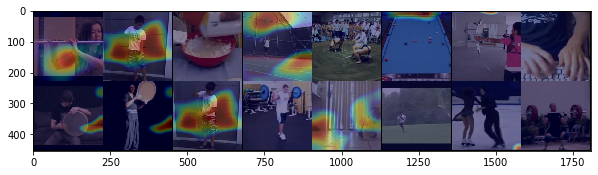

In [26]:
def visualize_cams(model, ds, num_imgs=16):
    img_grids = []
    c_gts = []
    
    plt.figure(figsize=(10,10))
    for _ in range(num_imgs):
        rand_ix = np.random.randint(len(ds))
        img, _, lab = ds[rand_ix]
        im = Image.fromarray(img[0].numpy())  # test only first frame

        img_tensor = transforms['test'](im)
        
        res_img, c_ix, scores = generate_cam_img(model, img_tensor.cuda(), activation_layer='layer4.2.bn3')#, lab=lab)
        
        img_grids.append(torch.as_tensor(res_img).permute(2,0,1))
        c_gts.append(idx2class[c_ix])
            
    img_grids = torchvision.utils.make_grid(torch.stack(img_grids)).permute(1,2,0).numpy()
    img_grids = cv2.cvtColor(img_grids, cv2.COLOR_BGR2RGB)
    plt.imshow(img_grids)
    
    print(c_gts)
    
visualize_cams(model, ds, num_imgs=16)

In [ ]:
model

In [ ]:
img, _ , lab = ds[9999]

In [ ]:
img.shape

In [ ]:
plt.imshow(img[0])

In [ ]:
transforms

In [ ]:
fileNames = np.array(ds.samples)[:, 0].tolist()
fileNames[:10]

In [ ]:
for fn in fileNames:
    cap = cv2.VideoCapture(fn)
    h,w = cap.get(cv2.CAP_PROP_FRAME_HEIGHT), cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    print(h,w)

In [ ]:
fileNames = np.array(datasets['test'].data.samples)[:, 0].tolist()
fileNames[:10]

In [ ]:
for fn in fileNames:
    h,w = Image.open(fn).size
    print(fn, h,w)